### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
def plot_tracked_values(states_tracks):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(2, 2, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    plt.show()

In [7]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [8]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [9]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [10]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [11]:
env = CabDriver()

In [12]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

In [13]:
agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0005,
    "discount_factor": 0.95,
    "batch_size": 32,
    "layers": [64, 64],
    "learning_rate": 0.001
}

agent_param = AgentParam(agent_param_dict)

agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

total_rewards = []

Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0005
discount_factor -> 0.95
batch_size -> 32
layers -> [64, 64]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                1365      
Total params: 7,893


In [14]:
Episodes = 15000

### DQN block

In [15]:
log_threshold = Episodes * 0.001
threshold = Episodes * 0.001
model_threshold = Episodes * 0.05

for episode in range(Episodes):

    # tracking total rewards, step count
    total_reward = 0

    state = env.reset()[2]
    is_finished = False

    current_episode = episode + 1

    while not is_finished:

        action = agent.get_action(state, episode, env.get_requests(state))

        reward = env.get_reward(state, action, Time_matrix)

        next_state, is_finished, episode_time_till_now = env.get_next_state(
            state, action, Time_matrix)

        agent.save_experience(state, action, reward, next_state, is_finished)

        # every time step do the training
        agent.train_model()
        total_reward += reward
        state = next_state

        # Store the rewards
        if is_finished and current_episode % log_threshold == 0:
            total_rewards.append(total_reward)
            print(
                "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                .format(current_episode, total_reward, agent.memory_length(),
                        episode_time_till_now, agent.epsilon))

    if (current_episode % model_threshold) == 0:
        agent.save("./dqn_cab_driver.h5")

    if (current_episode % threshold) == 0:
        agent.update_tracking_states()


episode: 15, rewards: -408.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9930244499087921
episode: 30, rewards: -248.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.9856046331277636
episode: 45, rewards: -204.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.978240256810975
episode: 60, rewards: -397.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9709309067103166
episode: 75, rewards: -203.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.9636761716729182
episode: 90, rewards: -123.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.9564756436180206
episode: 105, rewards: -438.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.9493289175140227
episode: 120, rewards: -182.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.9422355913556965
episode: 135, rewards: 37.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9351952661415752
episode: 150, rewards: -221.0, replay_buffer_size: 200

episode: 1155, rewards: 342.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.5615810221485976
episode: 1170, rewards: 445.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5573849270084361
episode: 1185, rewards: 549.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.5532201848611358
episode: 1200, rewards: 96.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5490865614388524
episode: 1215, rewards: 166.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.5449838242241788
episode: 1230, rewards: 318.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.5409117424370646
episode: 1245, rewards: 115.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.5368700870218357
episode: 1260, rewards: 299.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5328586306343094
episode: 1275, rewards: 207.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.528877147629006
episode: 1290, rewards: 344.0, replay_buffer_siz

episode: 2325, rewards: 872.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.3128605222155941
episode: 2340, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3105228530162886
episode: 2355, rewards: 835.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.30820265075309133
episode: 2370, rewards: 426.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.30589978491401315
episode: 2385, rewards: 837.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3036141259622436
episode: 2400, rewards: 837.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.30134554532886365
episode: 2415, rewards: 684.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.2990939154056147
episode: 2430, rewards: 564.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2968591095377198
episode: 2445, rewards: 787.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.29464100201675986
episode: 2460, rewards: 442.0, replay_buff

episode: 3480, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1756090071528298
episode: 3495, rewards: 1192.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.17429687375006353
episode: 3510, rewards: 979.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.17299454453615268
episode: 3525, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17170194625473562
episode: 3540, rewards: 1279.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.17041900619681816
episode: 3555, rewards: 979.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.1691456521966838
episode: 3570, rewards: 627.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1678818126278343
episode: 3585, rewards: 1292.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.16662741639896061
episode: 3600, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.16538239294994417
episode: 3615, rewards: 780.0, rep

episode: 4635, rewards: 790.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.09856975046602379
episode: 4650, rewards: 1096.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.09783325016599566
episode: 4665, rewards: 1322.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.09710225295583502
episode: 4680, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09637671771675602
episode: 4695, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09565660363721025
episode: 4710, rewards: 848.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09494187021059075
episode: 4725, rewards: 1331.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.09423247723295394
episode: 4740, rewards: 1039.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.09352838480075772
episode: 4755, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09282955330861709
episode: 4770, rewards: 1215.0

episode: 5775, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05574413584936331
episode: 5790, rewards: 1297.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.05532762619408756
episode: 5805, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0549142286761233
episode: 5820, rewards: 1210.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.054503920041751204
episode: 5835, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.054096677211002336
episode: 5850, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.05369247727636016
episode: 5865, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.053291297501471734
episode: 5880, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.052893115319868914
episode: 5895, rewards: 1515.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.05249790833369905
episode: 5910, rewards: 1

episode: 6915, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.031525161355699084
episode: 6930, rewards: 1417.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.03128961455017666
episode: 6945, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03105582773747264
episode: 6960, rewards: 1424.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.030823787767017136
episode: 6975, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030593481586500656
episode: 6990, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030364896241139812
episode: 7005, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030138018872948636
episode: 7020, rewards: 1369.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.02991283672001538
episode: 7035, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.029689337115784545
episode: 7050, rewards

episode: 8055, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.017828715180316715
episode: 8070, rewards: 1415.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.01769550746978937
episode: 8085, rewards: 1333.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.01756329507997277
episode: 8100, rewards: 1173.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.017432070573885093
episode: 8115, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.01730182657011329
episode: 8130, rewards: 1737.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.017172555742397823
episode: 8145, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01704425081922051
episode: 8160, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.016916904583395617
episode: 8175, rewards: 1283.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01679050987166381
episode: 8190, rewards: 

episode: 9195, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010083026448359005
episode: 9210, rewards: 1291.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.010007694099424876
episode: 9225, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009932924629672319
episode: 9240, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009858713833298956
episode: 9255, rewards: 1469.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00978505753592793
episode: 9270, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009711951594373078
episode: 9285, rewards: 1645.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00963939189640592
episode: 9300, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00956737436052432
episode: 9315, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00949589493572288
episode: 9330, rewards:

episode: 10335, rewards: 1718.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.005702642430188565
episode: 10350, rewards: 1544.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0056600400705093205
episode: 10365, rewards: 1786.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.005617756033326174
episode: 10380, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.005575787940150892
episode: 10395, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.005534133430267154
episode: 10410, rewards: 1213.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.005492790160597803
episode: 10425, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.005451755805573025
episode: 10440, rewards: 1629.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005411028056999519
episode: 10455, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005370604623930694
episode: 

episode: 11460, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0032496979294785256
episode: 11475, rewards: 1393.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0032254238366402825
episode: 11490, rewards: 1385.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.003201331118493042
episode: 11505, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0031774184198150586
episode: 11520, rewards: 963.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003153684395510721
episode: 11535, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003130127710534906
episode: 11550, rewards: 1755.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003106747039817876
episode: 11565, rewards: 1501.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.003083541068190733
episode: 11580, rewards: 1628.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0030605084903114563
episode

episode: 12585, rewards: 1585.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.001852052282955775
episode: 12600, rewards: 1618.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0018382213217706203
episode: 12615, rewards: 1665.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0018244937047692394
episode: 12630, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0018108686597695588
episode: 12645, rewards: 1371.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0017973454203592007
episode: 12660, rewards: 1535.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0017839232258523845
episode: 12675, rewards: 1601.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0017706013212471319
episode: 12690, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0017573789571827924
episode: 12705, rewards: 1638.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0017442553898979031
ep

episode: 13695, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010636377696692462
episode: 13710, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010556977985071653
episode: 13725, rewards: 1674.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001047817154374344
episode: 13740, rewards: 1592.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.001039995393982473
episode: 13755, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001032232077355469
episode: 13770, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010245267678047226
episode: 13785, rewards: 1345.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.001016879031904541
episode: 13800, rewards: 1728.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010092884394677642
episode: 13815, rewards: 1611.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010017545635215644
episo

episode: 14805, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.000611030867266762
episode: 14820, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000606472750067911
episode: 14835, rewards: 1678.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0006019486908708985
episode: 14850, rewards: 1583.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005974584351962005
episode: 14865, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005930017304657518
episode: 14880, rewards: 1890.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005885783259887368
episode: 14895, rewards: 1421.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005841879729474865
episode: 14910, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000579830424383485
episode: 14925, rewards: 1456.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0005755054351834771
epis

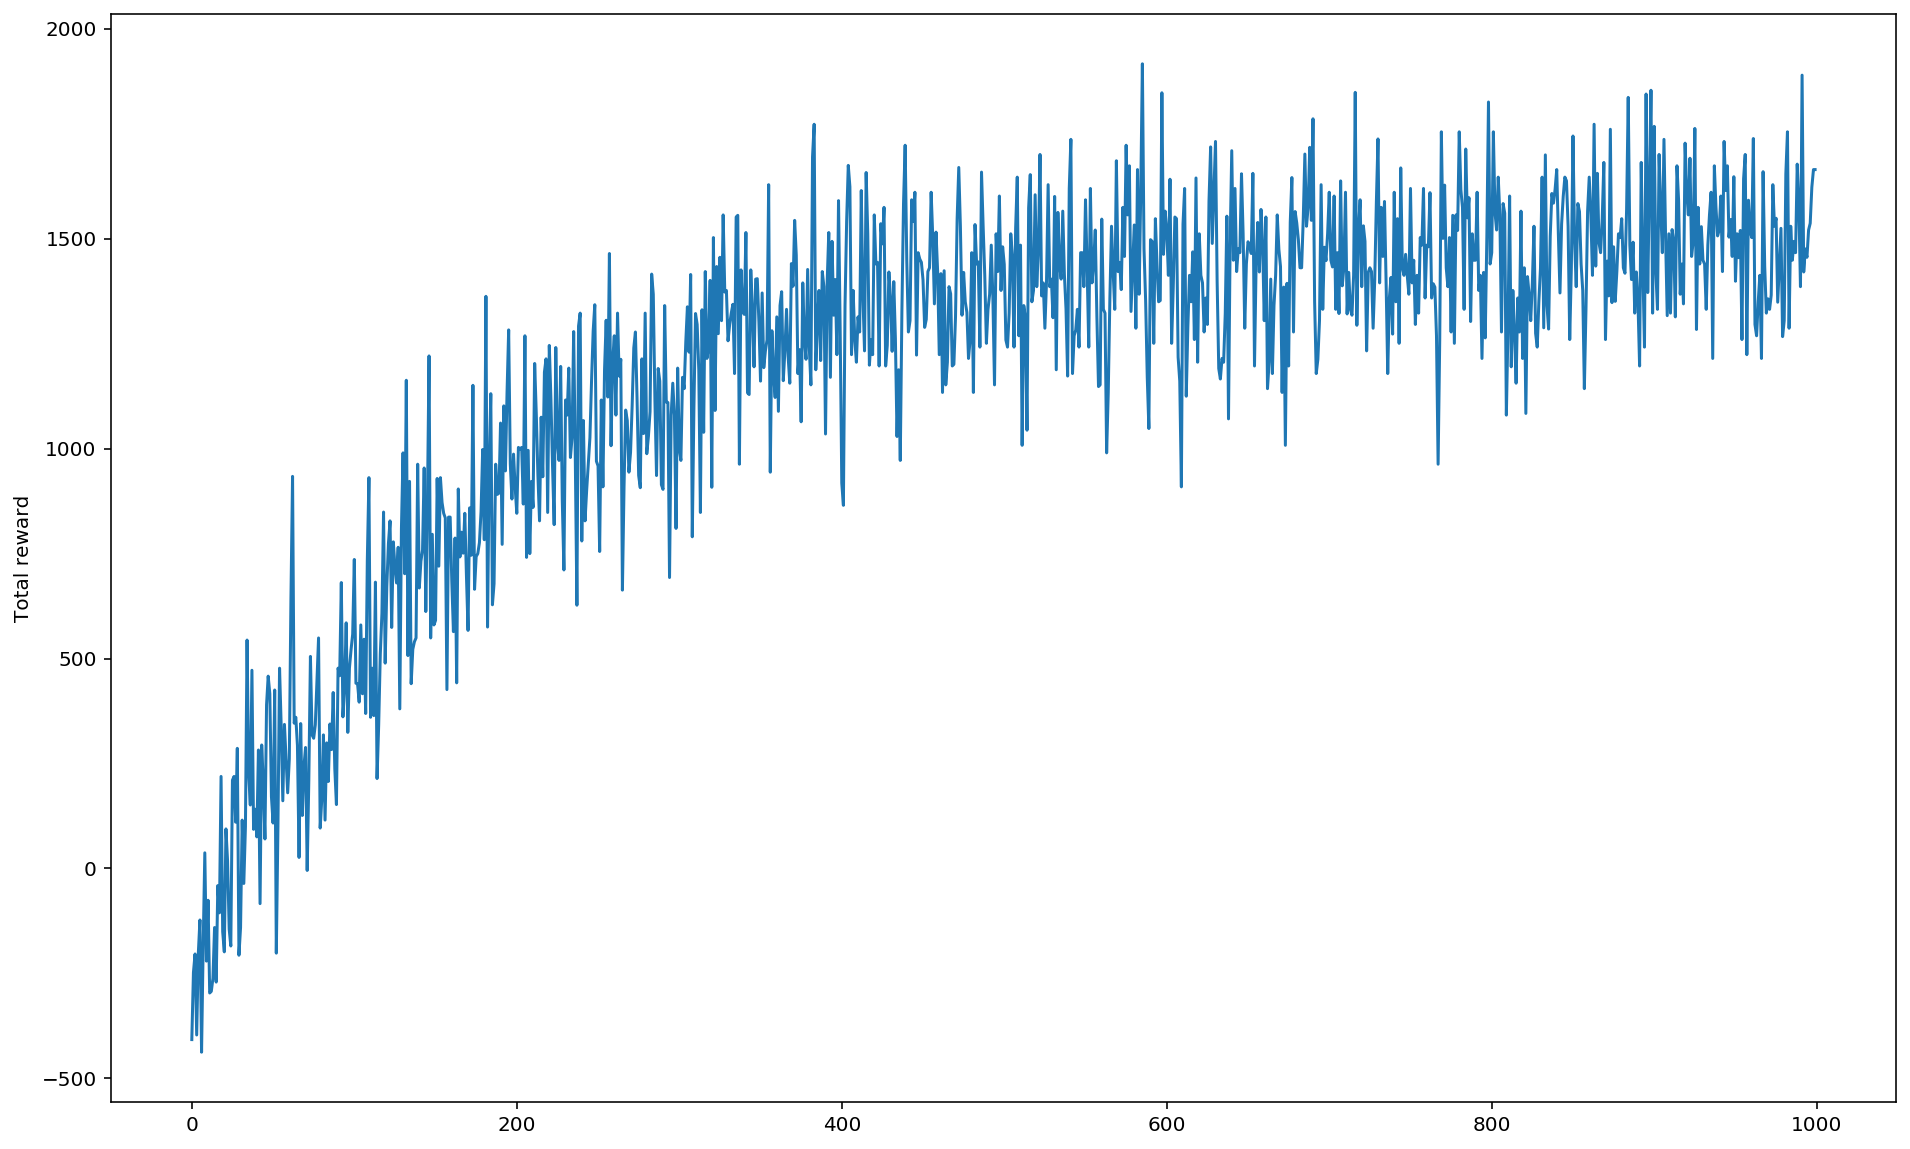

In [16]:
# Plotting total rewards
plt.figure(figsize=(16,10))
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

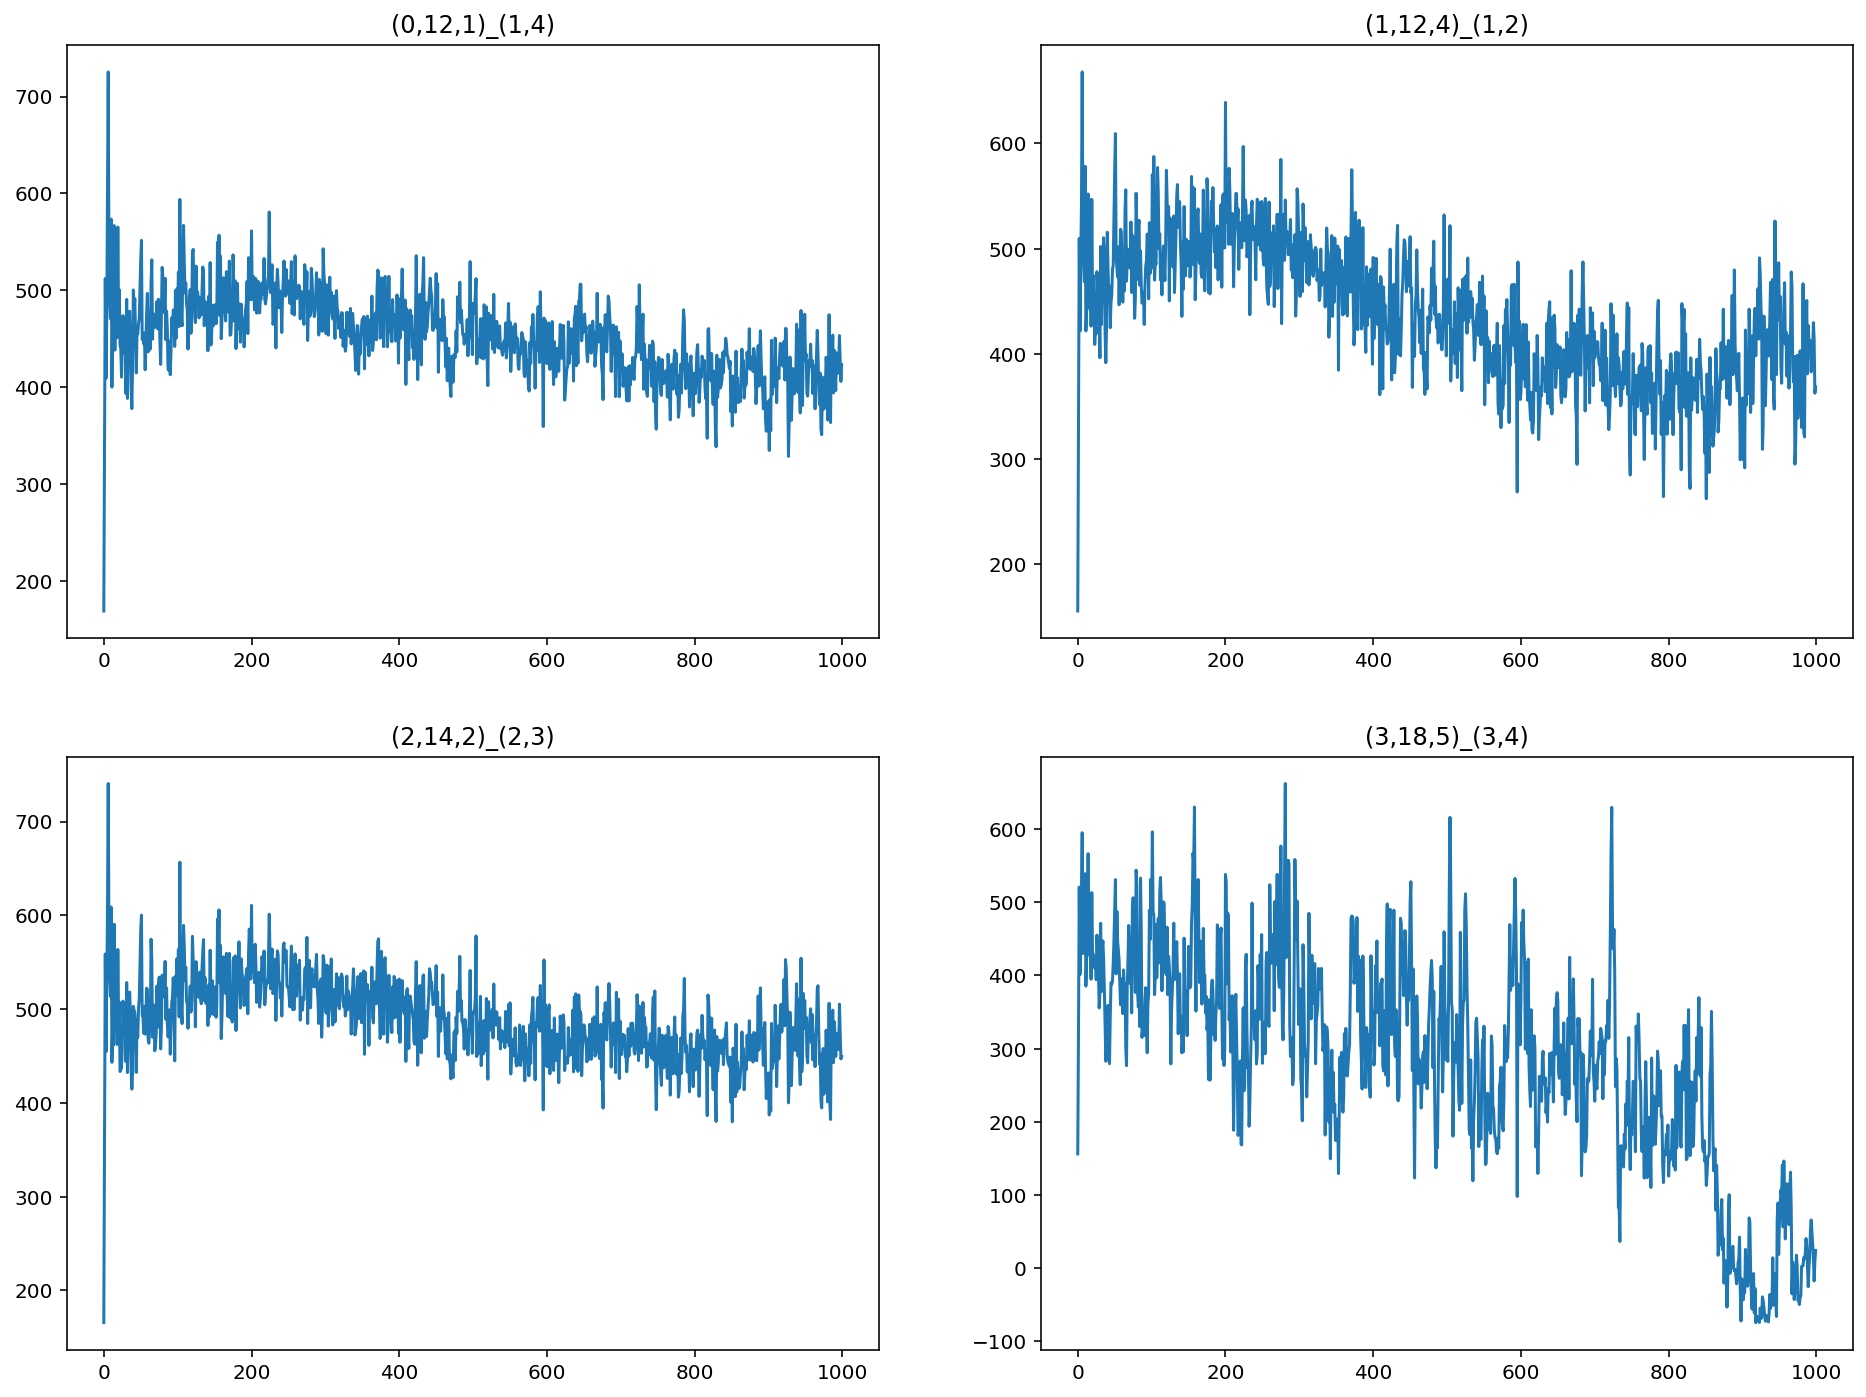

In [17]:
plot_tracked_values(agent.states_track)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)

time = np.arange(0,Episodes)
epsilon = []
for i in range(0,Episodes):
    epsilon.append(epsilon_greedy_policy.get_epsilon(i))

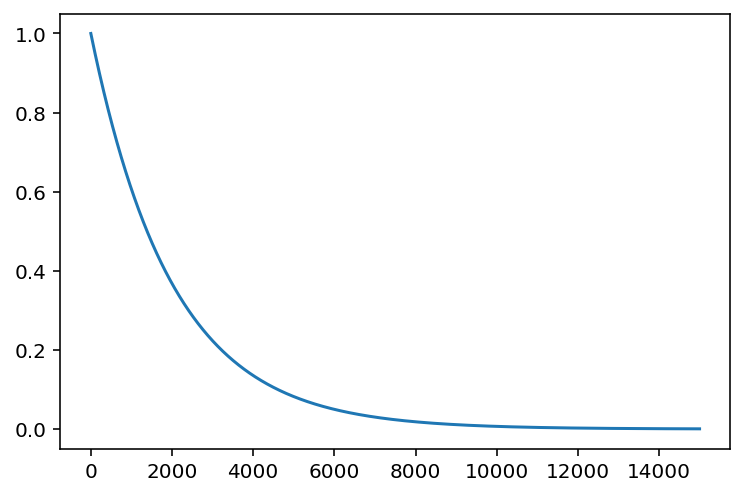

In [19]:
plt.plot(time, epsilon)
plt.show()